In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from catboost import CatBoostRegressor

from sklearn.linear_model import Ridge, Lasso, BayesianRidge

%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(10,6), dpi=180)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=15, titlepad=10)
plt.rc('animation', html='html5')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv
/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_10k.csv
/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_2k.csv
/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_100k.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv', index_col='id')

In [3]:
org = []
for n in [2, 10, 100]:
    df = pd.read_csv(f'/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_{n}k.csv')
    org.append(df)

org = pd.concat(org, axis=0)
org.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,rural,2,0.72,60,daylight,clear,True,False,afternoon,False,False,2,0.37
1,highway,4,0.95,45,daylight,foggy,False,True,evening,False,True,1,0.40
2,rural,1,0.72,25,night,rainy,False,False,evening,True,False,1,0.55
3,rural,4,0.86,70,dim,foggy,True,False,morning,True,True,1,0.56
4,highway,1,0.00,60,night,rainy,True,True,morning,True,True,3,0.54


In [4]:
train = pd.concat([train, org], axis=0, ignore_index=True)

In [5]:
train = train.drop_duplicates()

In [6]:
num_cols = test.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = test.select_dtypes(include='object').columns.to_list()

In [7]:
for col in num_cols:
    if test[col].dtype == 'float64':
        train[col] = train[col].astype('float32')
        test[col] = test[col].astype('float32')
        
    else:
        train[col] = train[col].astype('int32')
        test[col] = test[col].astype('int32')

for col in cat_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [8]:
features = ['road_type', 'num_lanes','speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents']

target = 'accident_risk'

# Feature Engineering

## Creating base risk feature based on domain knowledge

In [9]:
def risk(df):
    base_risk = (0.4 * df['curvature'] +
                 0.25 * (df['lighting'] == 'night').astype(int) +
                 0.1 * (df["weather"] != "clear").astype(int) +
                 0.2 * (df["speed_limit"] >= 60).astype(int) +
                 0.05 * (np.array(df["num_reported_accidents"] > 2).astype(int)
    ))
                 
    noise = np.random.normal(0, 0.05, df.shape[0])
    risk_score = np.clip(base_risk + noise, 0, 1)
    df["simulated_risk"] = np.round(risk_score, 2).astype('float32')

    return df

train = risk(train)
test = risk(test)

In [10]:
TE = []
for c in cat_cols:
    te_map = train.groupby(c)[target].mean()
    n = f"TE_{c}"
    print(f"{n}, ",end="")
 
    train[n] = train[c].map(te_map)
    test[n] = test[c].map(te_map)

    global_mean = train[target].mean()
    train[n].fillna(global_mean, inplace=True)
    test[n].fillna(global_mean, inplace=True)
    
    TE.append(n)

TE_road_type, TE_lighting, TE_weather, TE_time_of_day, 

In [11]:
def feature_engineering(df):
    
    df['speed_visibility'] = df['speed_limit'] * df['lighting'].map({'daylight': 0.5, 'dim': 1.0, 'night': 1.5}).fillna(1.0)
    df['curv_speed'] = df['curvature'] * df['speed_limit'] 
    df['curv_sq'] = df['curvature']**2
    df['speed_sq'] = df['speed_limit']**2
    df['curv_per_lane'] = df['curvature'] / (df['num_lanes'] + 1)
    df['risk_density'] = df['curv_speed'] / (df['num_lanes'] + 1)
    df['curve_night_risk'] = df['curvature'] * (df['lighting'] == 'night').astype('int32')
    df['curv_log'] = np.log1p(df['curvature'])
    df['speed_log'] = np.log1p(df['speed_limit'])
    df['meta_night'] = 0.2 * (df['lighting'] == 'night').astype('int32')
    df['meta_weather'] = 0.1 * (df['weather'] != 'clear').astype('int32')
    df['meta_speed'] = 0.2 * (df['speed_limit'] >= 60).astype('int32')
    df['meta_accidents'] = 0.1 * (df['num_reported_accidents'] > 2).astype('int32')

    df['curv_binned'] = pd.cut(df['curvature'], bins=10, labels=False).astype('int32')
    df['speed_binned'] = pd.cut(df['speed_limit'], bins=10, labels=False).astype('int32')

    return df

train = feature_engineering(train)
test = feature_engineering(test)

In [12]:
num_cols = test.select_dtypes(include='number').columns.to_list()
cat_cols = test.select_dtypes(exclude='number').columns.to_list()

In [13]:
for c in cat_cols:
    train[c] = pd.Categorical(train[c]).codes
    test[c] = pd.Categorical(test[c]).codes

In [14]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,...,risk_density,curve_night_risk,curv_log,speed_log,meta_night,meta_weather,meta_speed,meta_accidents,curv_binned,speed_binned
0,2,2,0.06,35,0,2,0,1,0,0,...,0.700000,0.0,0.058269,3.583519,0.0,0.1,0.0,0.0,0,2
1,2,4,0.99,35,0,0,1,0,1,1,...,6.930000,0.0,0.688135,3.583519,0.0,0.0,0.0,0.0,9,2
2,1,4,0.63,70,1,0,0,1,2,1,...,8.820000,0.0,0.488580,4.262680,0.0,0.0,0.2,0.0,6,9
3,0,4,0.07,35,1,2,1,1,2,0,...,0.490000,0.0,0.067659,3.583519,0.0,0.1,0.0,0.0,0,2
4,1,1,0.58,60,0,1,0,0,1,1,...,17.399999,0.0,0.457425,4.110874,0.0,0.1,0.2,0.0,5,7


In [15]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 629059 entries, 0 to 629753
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   road_type               629059 non-null  int8
 1   num_lanes               629059 non-null  int32
 2   curvature               629059 non-null  float32
 3   speed_limit             629059 non-null  int32
 4   lighting                629059 non-null  int8
 5   weather                 629059 non-null  int8
 6   road_signs_present      629059 non-null  int8
 7   public_road             629059 non-null  int8
 8   time_of_day             629059 non-null  int8
 9   holiday                 629059 non-null  int8
 10  school_season           629059 non-null  int8
 11  num_reported_accidents  629059 non-null  int32
 12  accident_risk           629059 non-null  float64
 13  simulated_risk          629059 non-null  float32
 14  TE_road_type            629059 non-null  float64
 15  TE_

# Splitting the data into training and testing sets

In [16]:
X = train.copy()
y = X.pop('accident_risk')
X_test = test.copy()

# Conducting optuna study


In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=2)
n_folds = 5

In [18]:
# Parameters acquired from Optuna study

xgb_param = {
    'n_estimators': 1600,
    'learning_rate': 0.05036086563157658,
    'max_depth': 5,
    'reg_alpha': 1.7078790750979551, 
    'reg_lambda': 0.04303317633957419,
    'subsample': 0.6010146163838317,
    'colsample_bytree': 0.8088494830103302,
    'eval_metric': 'rmse',
    'random_state':2, 
    'early_stopping_rounds': 100,
    'device': 'cuda',
    'objective': 'reg:squarederror',
}

cat_param = {
    'iterations': 2000,
    'learning_rate': 0.08462849871988642,
    'depth': 7,
    'l2_leaf_reg': 2.1397487441799643,
    "loss_function": "RMSE",
    'eval_metric': 'RMSE',
    'task_type':'GPU', 
    'random_state': 2,
    'early_stopping_rounds': 100,
    'verbose': 0,
}

lgbm_param = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.015047232662609947,
    "num_leaves": 124,
    "bagging_fraction": 0.6338824787124612,
    "reg_alpha": 0.2869136891325499,
    "reg_lambda": 2.4855353033908525,
    "max_depth": 9,
    "n_estimators": 1000,
    'min_data_in_leaf': 70,
    "device_type": "gpu",
    "random_state": 2,
    'verbose': -1,
    'n_jobs': -1,
}

xgb = XGBRegressor(**xgb_param)
cat = CatBoostRegressor(**cat_param)
lgbm = LGBMRegressor(**lgbm_param)

In [19]:
meta_train = np.zeros((len(y), 3))
meta_test = np.zeros((len(X_test), 3))

scores = []

In [20]:
for fold, (train_index, valid_index) in enumerate(kf.split(X, y), start=1):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    weights = np.where(y_train > 0.8, 5.0, 1.0)
    
    xgb.fit(X_train, y_train, sample_weight=weights, eval_set=[(X_valid, y_valid)], verbose=0)
    xgb_pred = xgb.predict(X_valid)
    
    cat.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], sample_weight=weights)
    cat_pred = cat.predict(X_valid)
    
    lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stopping(200), log_evaluation(period=0)], sample_weight=weights)
    lgbm_pred = lgbm.predict(X_valid)

    ensemble_pred = 0.4 * xgb_pred + 0.3 * cat_pred + 0.3 * lgbm_pred
    rmse = np.sqrt(mean_squared_error(y_valid, ensemble_pred))
    scores.append(rmse)
    print(f"Fold {fold}: {rmse:.5f}")

simple_avg_score = np.mean(scores)
print(f"\nSimple Average CV Score: {simple_avg_score:.5f} (+/- {np.std(scores):.5f})")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [09:35:09] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 w

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 0.05641
Fold 1: 0.05623
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 0.0562456
Fold 2: 0.05610
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.0562279
Fold 3: 0.05608
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.0565533
Fold 4: 0.05639
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.056532
Fold 5: 0.05637

Simple Average CV Score: 0.05623 (+/- 0.00013)


<function matplotlib.pyplot.show(close=None, block=None)>

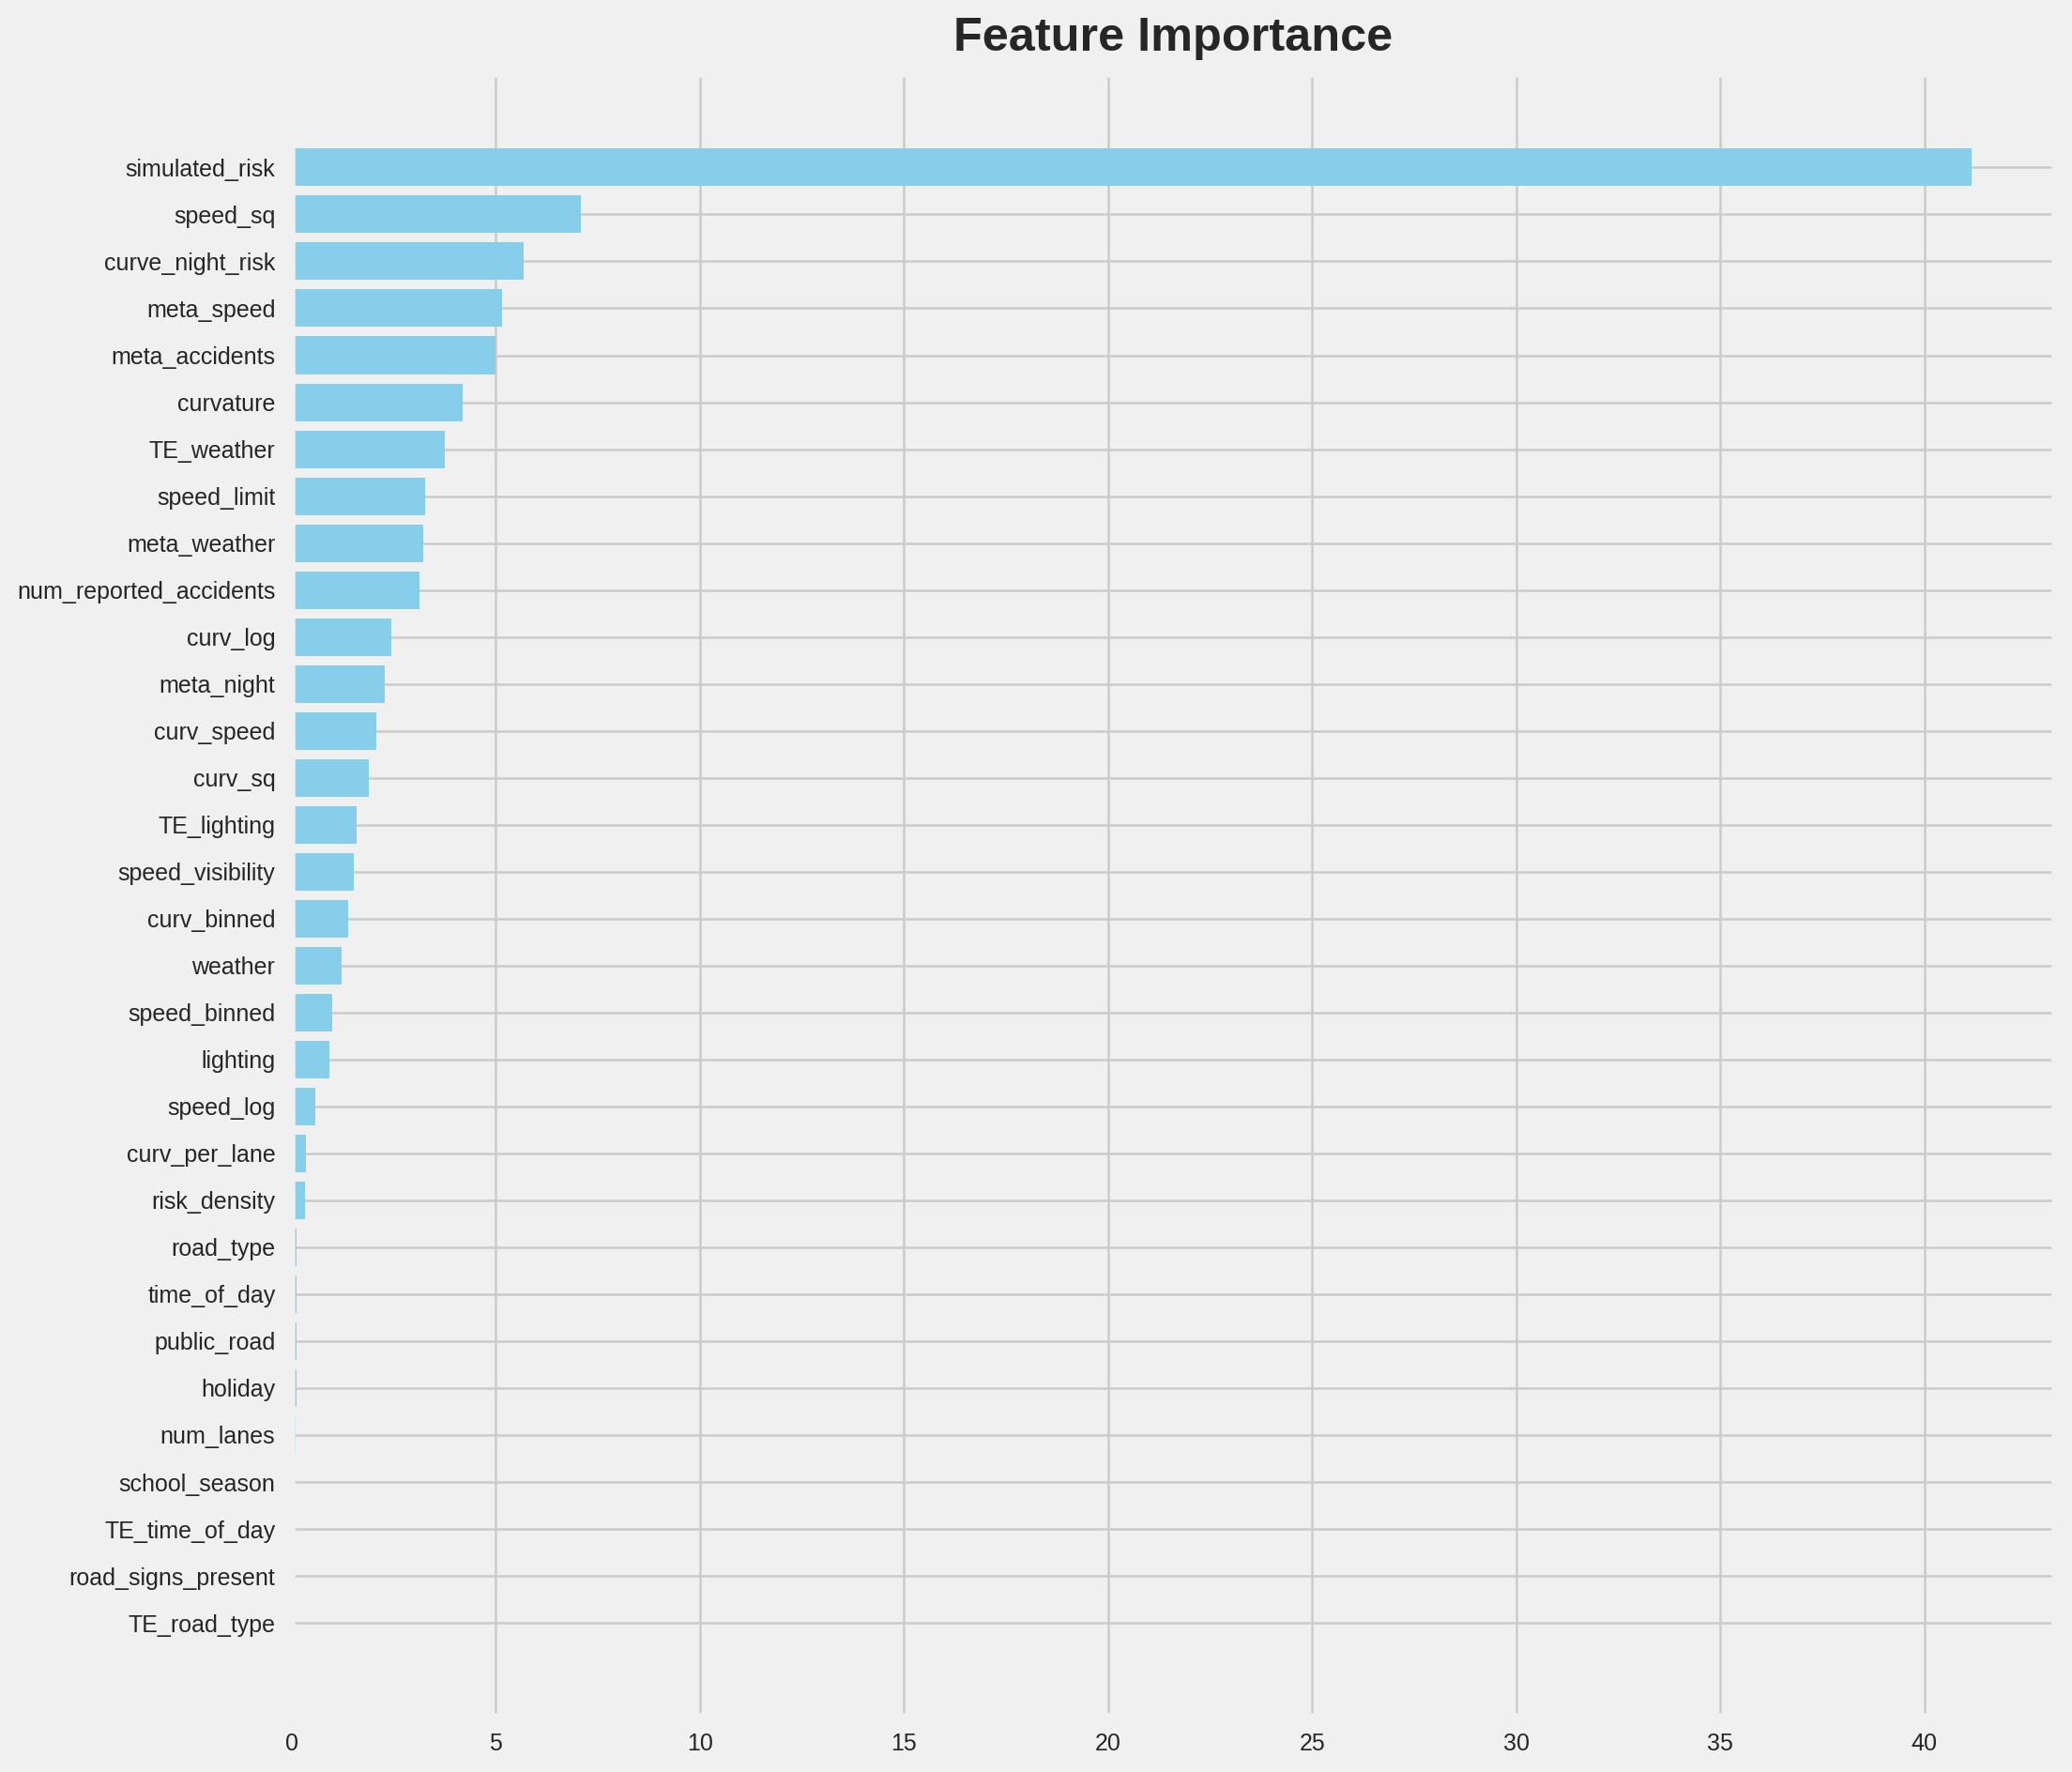

In [21]:
plt.style.use('fivethirtyeight')
importances = cat.feature_importances_
columns = X.columns

df_importances = pd.DataFrame({'Feature': columns, 'Importance': importances})
df_importances = df_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 12))
plt.barh(df_importances['Feature'], df_importances['Importance'], color='skyblue')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

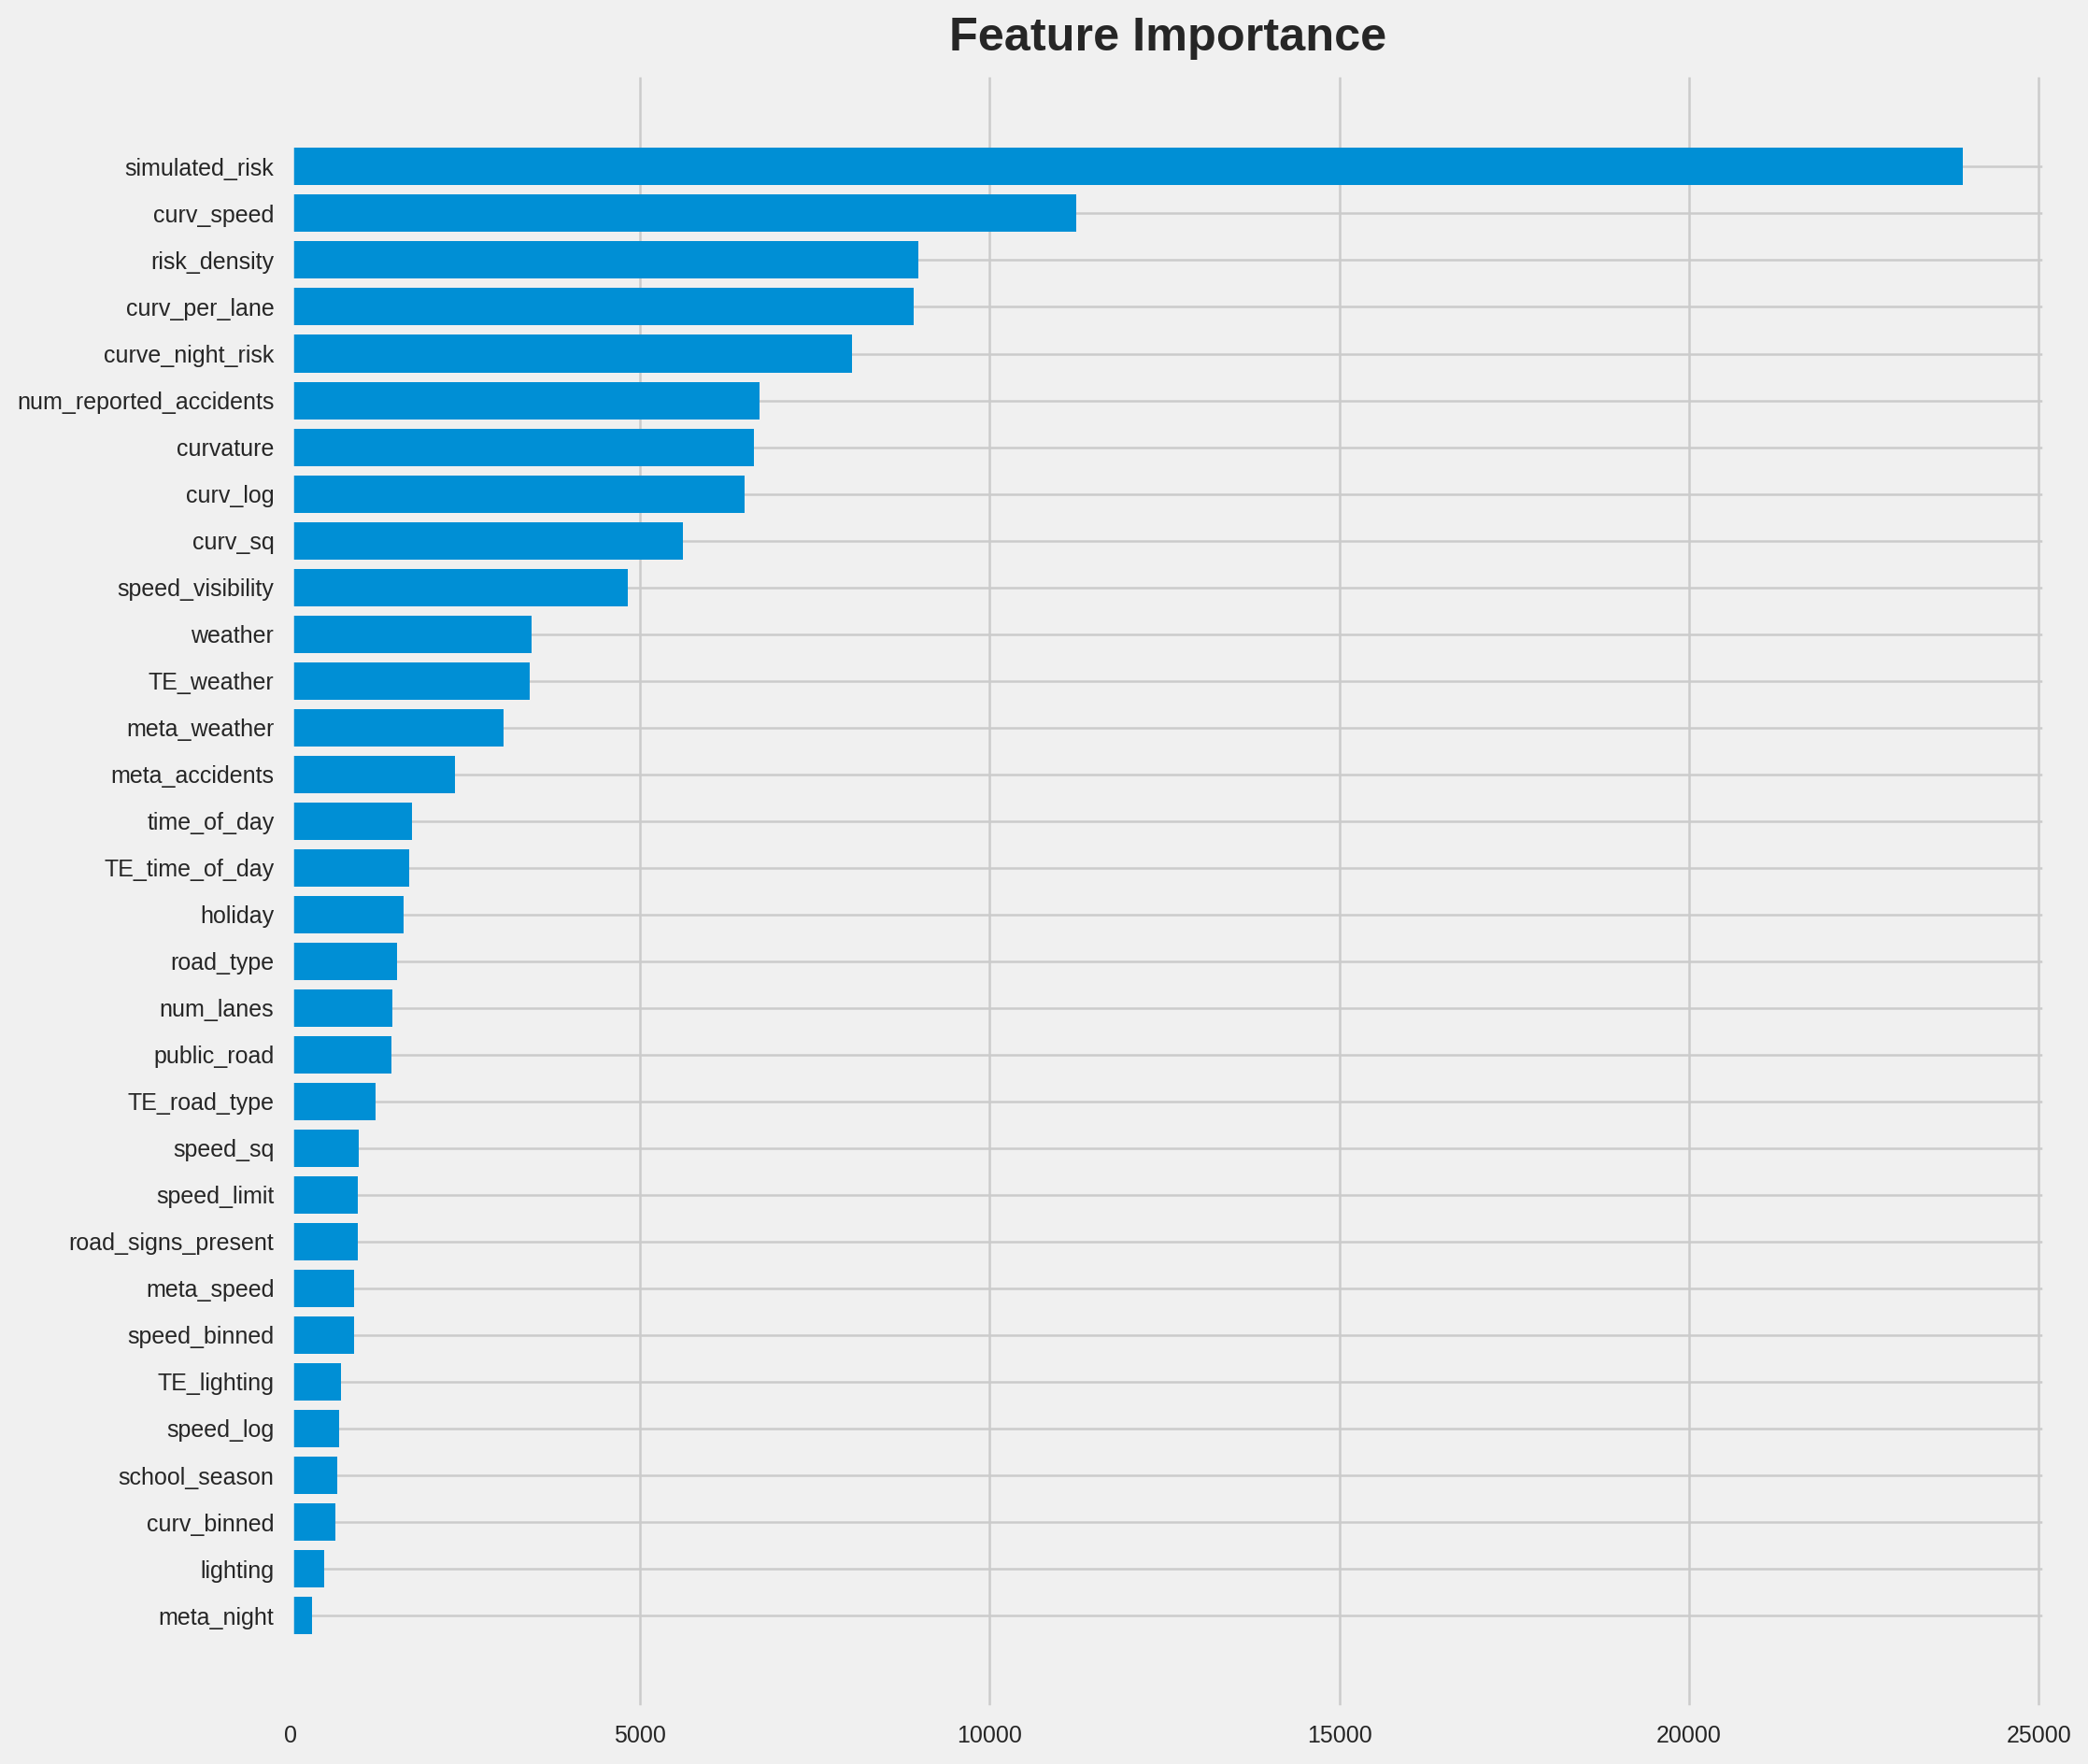

In [22]:
plt.style.use('fivethirtyeight')
importances = lgbm.feature_importances_
columns = X.columns

df_importances = pd.DataFrame({'Feature': columns, 'Importance': importances})
df_importances = df_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 12))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show

In [23]:
xgb_test = xgb.predict(X_test)
lgbm_test = lgbm.predict(X_test)
cat_test = cat.predict(X_test)

test_preds = 0.4 * xgb_test + 0.3 * cat_test + 0.3 * lgbm_test

In [24]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')
sub['accident_risk'] = test_preds
sub.to_csv('submission.csv', index=False)
sub.head()

,id,accident_risk
0,517754,0.293683
1,517755,0.121801
2,517756,0.182762
3,517757,0.342361
4,517758,0.381825
